# LSTM - Long Short Term Memory Networks
Las redes LSTM son un tipo de red neuronal recurrente (RNN) con capacidad de retener y utilizar información a largo plazo. Mediante el uso de unidades de momoria especializadas, las LSTM son capaces de manejar dependencias a largo plazo en secuencias de datos y evitar el desvanecimiento del gradiente, problema que podía ocasionar que las RNN simples olvidaran información relevante en secuencias largas. 

Se trata de una RNN con una celda de memoria diseñada específicamente para superar el problema del desvanecimiento del gradiente. Además, su estructura de "puertas"...

![LSTM.png](.git/LSTM.png)

In [2]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, Flatten, Dropout, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)

## Cargar los datos y dividirlos en training y validation
Se cargan los datos preprocesados y se dividen en dos conjuntos: training y validation.

In [4]:
df = pd.read_csv('./data/goemotions_clean.csv', sep=",")
df.head()

,text,emotion
0,Shhh dont give idea,anger
1,Thank much kind stranger I really need,gratitude
2,Ion know would better buy trim make hard dose,neutral
3,Im honestly surprised We fallen much farther,excitement
4,Jurisprudence fetishist get technicality,neutral


In [5]:
# Dividir el dataset en train y validation
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['emotion'], test_size=0.2, random_state=0)

## Preprocesamiento de los datos
Para poder utilizar los datos en la red neuronal, es necesario preprocesarlos. El texto debe ser convertido a números, ya que las redes neuronales no pueden trabajar con texto. Para ello, se utiliza la clase Tokenizer de Keras, que convierte el texto a secuencias de números. Además, se añade padding a las secuencias para que todas tengan la misma longitud.

### Tokenization, Padding and Sequencing

In [6]:
def tokenization(tokenizer: Tokenizer, X_train: pd.Series, X_test: pd.Series) -> tuple[np.ndarray, np.ndarray, int, int]:
    # Fit tokenizer on train set
    tokenizer.fit_on_texts(X_train)

    # Convert text to sequences for both train and test sets
    train_sequences = tokenizer.texts_to_sequences(X_train)
    test_sequences = tokenizer.texts_to_sequences(X_test)

    # Get length of the longest sequence
    max_seq_len = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))

    # Get vocabulary size
    vocab_size = len(tokenizer.word_index) + 1  # +1 for zero padding
    
    # Applying padding to both train and test sets
    train_padded = pad_sequences(train_sequences, maxlen=max_seq_len, padding="post")
    test_padded = pad_sequences(test_sequences, maxlen=max_seq_len, padding="post")

    return train_padded, test_padded, max_seq_len, vocab_size, tokenizer

In [7]:
# Define tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
# Obtain padded train and test sequences, length of longest sequence and vocabulary size
train_padded, val_padded, max_seq_len, vocab_size, tokenizer = tokenization(tokenizer, X_train, X_val)

In [8]:
# Convertir output a números
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

## Modelo de la red neuronal LSTM

In [9]:
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_seq_len))

# Add Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.5, dropout=0.5)))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.01))) # Anadimos una regularización L2 para penalizar los pesos grandes y ver si disminuye el overfit

# Output layer
model.add(Dense(23, activation="softmax"))

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\belus\anaconda3\envs\ADNE\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [10]:
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

In [11]:
model_path = os.path.join(models_dir, "lstm_l2_model.keras")

In [32]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4, restore_best_weights=True)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [33]:
history = model.fit(
    train_padded, np.array(y_train),
    epochs = 20,
    batch_size = 64,
    shuffle = True,
    validation_data = (val_padded, np.array(y_val)),
    callbacks = [es, mc]
)

Epoch 1/20
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3493 - loss: 2.1608
Epoch 1: val_loss improved from inf to 2.38432, saving model to ./models\lstm_l2_model.keras
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 95s 71ms/step - accuracy: 0.3493 - loss: 2.1608 - val_accuracy: 0.3152 - val_loss: 2.3843
Epoch 2/20
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3575 - loss: 2.1166
Epoch 2: val_loss did not improve from 2.38432
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 99s 74ms/step - accuracy: 0.3575 - loss: 2.1166 - val_accuracy: 0.3028 - val_loss: 2.4156
Epoch 3/20
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3626 - loss: 2.0707
Epoch 3: val_loss did not improve from 2.38432
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 97s 72ms/step - accuracy: 0.3626 - loss: 2.0707 - val_accuracy: 0.2937 - val_loss: 2.4548
Epoch 4/20
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3647 - loss: 2.0345
Epoch 4: val_loss did not improve from 2.38432
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 97s 72ms/step - 

In [34]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 19, 128)        │     3,526,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         1,495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,421,383 (43.57 MB)

 Trainable params: 3,807,127 (14.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,614,256 (29.05 MB)

None


In [35]:
def plot_metric_curves(epochs, train_curve, val_curve, train_color, val_color, metric, epochs_interval: int = 1):
    # Set graphics format as svg
    set_matplotlib_formats('svg')
    # Add grid
    sns.set_style("whitegrid")
    # Set figure size
    plt.figure(figsize=(12,8), dpi=200)
    # Plot curves
    plt.plot(epochs, train_curve, color=train_color, linewidth=2, label=f'Training {metric.lower()}')
    plt.plot(epochs, val_curve, color=val_color, linewidth=2, label=f'Validation {metric.lower()}')
    # Set title and labels
    plt.title(f'Training and validation {metric.lower()}', fontsize=20)
    plt.xlabel("Epochs", fontsize=15)
    plt.ylabel(metric.capitalize(), fontsize=15)
    # Show epoch values in x-axis in the specified interval
    plt.xticks(epochs[::epochs_interval])
    # Set max x-axis as the last epoch + 1
    plt.xlim(0, epochs[-1] + 1)
    # Remove top and right spines
    sns.despine(left=True, bottom=True)
    # Put the legend outside of the plot
    plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)
    plt.show()
    return

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

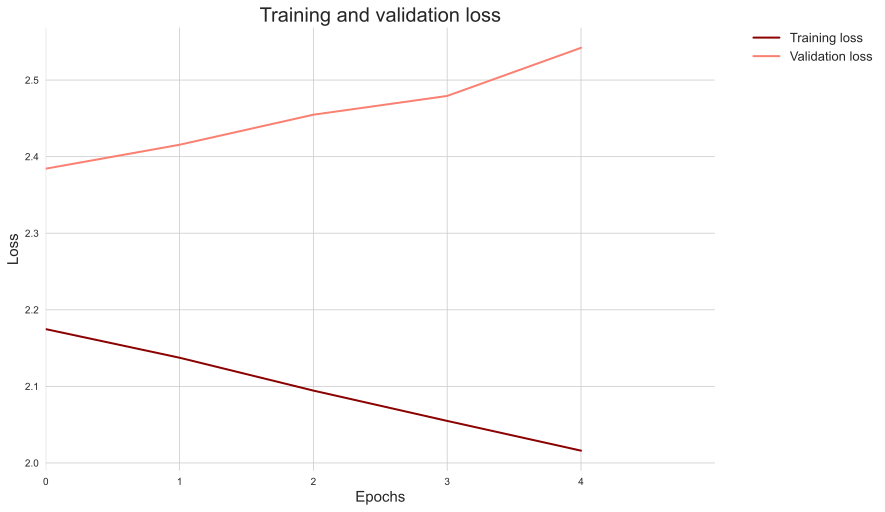

In [37]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "darkred", "salmon", "Loss", 1)

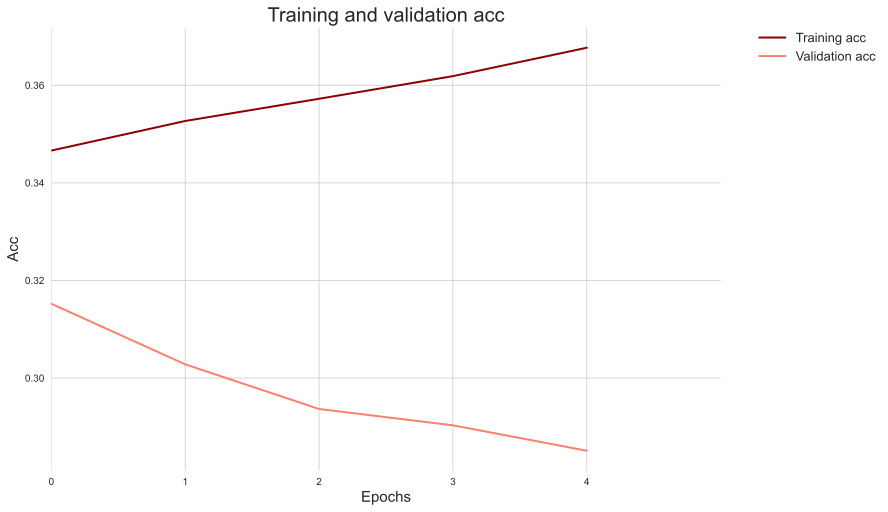

In [38]:
plot_metric_curves(epochs, acc, val_acc, "darkred", "salmon", "acc", 1)

### Predicciones

In [39]:
# Predecir las emociones en el conjunto de validación
y_pred_probs = model.predict(val_padded)

# Obtener las etiquetas originales de las emociones
y_val_labels = label_encoder.inverse_transform(y_val)
emotion_labels = label_encoder.classes_

673/673 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


In [40]:
emotion_to_emoji = {
    'admiration': '🤩',
    'amusement': '😄',
    'anger': '😡',
    'annoyance': '😑',
    'approval': '👍',
    'caring': '🥰',
    'confusion': '😕',
    'curiosity': '🤔',
    'desire': '😏',
    'disappointment': '😞',
    'disapproval': '👎',
    'disgust': '🤢',
    'embarrassment': '😳',
    'excitement': '😃',
    'fear': '😨',
    'gratitude': '🙏',
    'joy': '😀',
    'love': '❤️',
    'neutral': '😐',
    'optimism': '😊',
    'realization': '😲',
    'sadness': '😢',
    'surprise': '😮'
}

In [41]:
# Dataframe con texto, emoción real y top 3 de emociones predichas con sus probabilidades
df_results = pd.DataFrame(columns=['text', 'top1', 'top2', 'top3'])
df_results['text'] = X_val

# Obtener las etiquetas de las emociones predichas
top1_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -1]]
top2_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -2]]
top3_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -3]]

# Mapear las emociones a emojis
top1_labels = [emotion_to_emoji[label] for label in top1_labels]
top2_labels = [emotion_to_emoji[label] for label in top2_labels]
top3_labels = [emotion_to_emoji[label] for label in top3_labels]

# Obtener las probabilidades de las emociones predichas
top1_probs = y_pred_probs.max(axis=1) * 100  # Multiplicar por 100 para obtener el porcentaje
top2_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -2]] * 100
top3_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -3]] * 100

# Asignar valores al DataFrame
df_results['top1'] = [f'{label} {prob:.0f}%' for label, prob in zip(top1_labels, top1_probs)]
df_results['top2'] = [f'{label} {prob:.0f}%' for label, prob in zip(top2_labels, top2_probs)]
df_results['top3'] = [f'{label} {prob:.0f}%' for label, prob in zip(top3_labels, top3_probs)]

# Resetear el índice
df_results.reset_index(drop=True, inplace=True)

df_results.head()


,text,top1,top2,top3
0,Maybe could put context wa responding someone ...,😐 37%,😕 13%,😑 11%
1,NAME like picking choosing life work fact work,😐 32%,👍 11%,🤩 9%
2,How people eat paper plate theyre bbq,😐 38%,🤔 21%,😕 16%
3,Thank voice reason people keep screaming Vatic...,🙏 92%,😐 2%,🤩 2%
4,Gotta love trailing minute,❤️ 56%,🤩 10%,😐 10%
